### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
import torch
import torch.nn.functional as F
import torch.optim as optim

import torchvision

from torch.utils.data import DataLoader

In [4]:
from collections import namedtuple
from tqdm.notebook import tqdm
import sys

In [5]:
import skimage

In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FitFailedWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
import random
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEEtorchmetricsD"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 123
seed_everything(seed)

### Подгрузка данных

In [33]:
og_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((64, 64)),
                                               torchvision.transforms.ToTensor()])

In [34]:
dataset = torchvision.datasets.ImageFolder('./classification', 
                                           transform=og_transform)

In [35]:
train_size = int(0.70 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [36]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [37]:
len(dataset), len(train_dataset), len(val_dataset), len(test_dataset)

(722, 505, 108, 109)

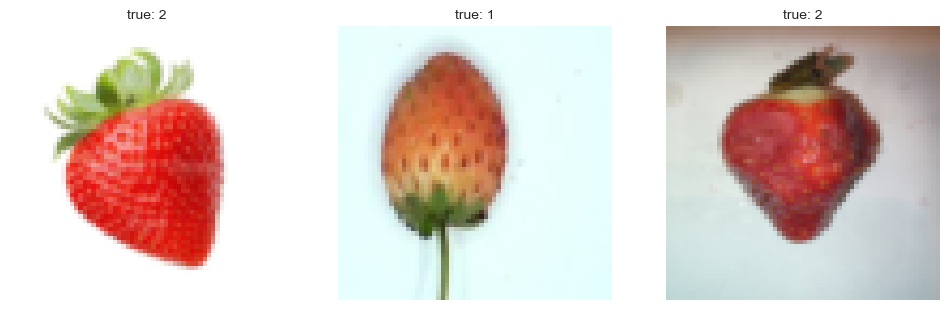

In [38]:
images_num = 3

fig, ax = plt.subplots(1, images_num, figsize=(12,8))

image_indices = [random.randint(0, len(train_dataset)) for _ in range(images_num)]

for i, ind in enumerate(image_indices):
    image, label = train_dataset[ind]
    ax[i].imshow(image.view(3, -1).T.reshape((64, 64, 3)).numpy())
    ax[i].axis('off')
    ax[i].set_title(f"true: {label}", fontsize=10)

In [163]:
# images_num = 12

# rows = 3
# cols = images_num // rows
# images_num = cols * rows

# fig, ax = plt.subplots(rows, cols, figsize=(12,8))

# image_indices = [random.randint(0, len(train_dataset)) for _ in range(images_num)]

# j = 0
# for row in range(0, rows):
#     for col in range(0, cols):
#         ind = image_indices[j]
#         image, label = train_dataset[ind]
#         ax[row][col].imshow(image.view(3, -1).T.reshape((224, 224, 3)).numpy())
#         ax[row][col].axis('off')
#         ax[row][col].set_title(f"true: {label}", fontsize=10)
#         j += 1

## Классические алгоритмы машинного обучения

Создадим функцию, которая генерирует по каждому каналу трёхканального тензора изображения статистические признаки - среднее арифметическое, стандартное отклонение, коэффициент вариации, децили, размах.

In [14]:
#             LAB_array = np.apply_along_axis(skimage.color.rgb2lab, 0, RGB_array)
#             arrays = [RGB_array, LAB_array]
#             arrays = [LAB_array]

In [15]:
def create_statistical_features(dataset):
    
    features_list = []
    target_list = []

    n = len(dataset)
    
    with tqdm(total=n) as prbar:
    
        for i in range(n):
            
            image, target = dataset[i]
            
            target_list.append(target)
            
            RGB_array = image.view(3, -1).numpy() / 255
            arrays = [RGB_array]
            all_features_list = []
            
            for array in arrays:
                mean_feature = array.mean(axis=1)
                std_feature = array.std(axis=1)
                cv = std_feature / mean_feature
                deciles = np.quantile(array, np.arange(0, 1.1, 0.1).tolist(), axis=1)
                range_feature = deciles[-1] - deciles[0]
                array_features_list = mean_feature.tolist() + std_feature.tolist() + cv.tolist() \
                    + deciles.flatten().tolist() + range_feature.tolist()
                all_features_list += array_features_list
            
            features_list.append(all_features_list)
            
            prbar.update(1)
        
        features_df = pd.DataFrame(data=features_list)
        target_series = pd.Series(target_list)
    
    return features_df, target_series


Применим к обучающей и тестовой выборкам.

In [16]:
train_features_df, train_target_series = create_statistical_features(train_dataset)

  0%|          | 0/505 [00:00<?, ?it/s]

In [17]:
val_features_df, val_target_series = create_statistical_features(val_dataset)

  0%|          | 0/108 [00:00<?, ?it/s]

In [18]:
test_features_df, test_target_series = create_statistical_features(test_dataset)

  0%|          | 0/109 [00:00<?, ?it/s]

Приступим к выбору и обучению моделей.

#### Logistic Regression

In [19]:
train_val_features_df = pd.concat([train_features_df, val_features_df], ignore_index=True)
train_val_target_series = pd.concat([train_target_series, val_target_series], ignore_index=True)
split_index = [-1 if x in train_features_df.index else 0 for x in train_val_features_df.index]
pds = PredefinedSplit(test_fold=split_index)

In [20]:
base_log_reg = LogisticRegression(solver='saga')

In [21]:
log_reg_params = {
    'penalty': ('l1', 'l2', 'elasticnet'),
    'C': np.arange(0.1, 5, 0.2)
}

log_reg_gs = GridSearchCV(
    estimator=base_log_reg,
    cv=pds,
    param_grid=log_reg_params,
    scoring='accuracy'
)

In [22]:
log_reg_gs.fit(
    train_val_features_df, 
    train_val_target_series
)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(solver='saga'),
             param_grid={'C': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9]),
                         'penalty': ('l1', 'l2', 'elasticnet')},
             scoring='accuracy')

In [23]:
log_reg_best_params = log_reg_gs.best_params_

In [24]:
log_reg = LogisticRegression(solver='saga', **log_reg_best_params)
log_reg.fit(
    train_features_df,
    train_target_series
)

LogisticRegression(C=2.5000000000000004, penalty='l1', solver='saga')

In [25]:
accuracy_score(log_reg.predict(test_features_df), test_target_series.values)

0.9174311926605505

In [26]:
lin_reg = LinearRegression()

In [27]:
lin_reg.fit(train_features_df, train_target_series)

LinearRegression()

In [28]:
accuracy_score(np.round(np.clip(lin_reg.predict(test_features_df), 0, 2)), test_target_series.values)

0.908256880733945

#### Support Vector Machines

In [29]:
base_svc = SVC()

In [30]:
svc_params = {
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    'C': np.arange(0.1, 5, 0.2)
}

In [31]:
svc_gs = GridSearchCV(
    estimator=base_svc,
    cv=pds,
    param_grid=svc_params,
    scoring='accuracy',
    n_jobs=-1
)

In [32]:
svc_gs.fit(
    train_val_features_df, 
    train_val_target_series
)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9]),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy')

In [33]:
svc_best_params = svc_gs.best_params_
print(svc_best_params)

{'C': 2.7000000000000006, 'kernel': 'rbf'}


In [34]:
svc = SVC(**svc_best_params)
svc.fit(
    train_features_df, 
    train_target_series
)

SVC(C=2.7000000000000006)

In [35]:
accuracy_score(svc.predict(train_features_df), train_target_series)

0.9148514851485149

In [36]:
accuracy_score(svc.predict(val_features_df), val_target_series)

0.9166666666666666

In [37]:
accuracy_score(svc.predict(test_features_df), test_target_series)

0.9357798165137615

#### K-Nearest Neighbors

In [38]:
base_knn = KNeighborsClassifier()

In [39]:
knn_params = {'weights': ('uniform', 'distance'),
              'n_neighbors': list(range(1, 30)),
              'p': [1, 2]}

In [40]:
knn_gs = GridSearchCV(
    estimator=base_knn,
    cv=pds,
    param_grid=knn_params,
    scoring='accuracy',
    n_jobs=-1
)

In [41]:
knn_gs.fit(
    train_val_features_df, 
    train_val_target_series
)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29],
                         'p': [1, 2], 'weights': ('uniform', 'distance')},
             scoring='accuracy')

In [42]:
knn_best_params = knn_gs.best_params_
print(knn_best_params)

{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}


In [43]:
knn = KNeighborsClassifier(**knn_best_params)
knn.fit(
    train_features_df,
    train_target_series
)

KNeighborsClassifier(n_neighbors=8, p=1, weights='distance')

In [44]:
accuracy_score(knn.predict(test_features_df), test_target_series)

0.944954128440367

In [45]:
base_knn_reg = KNeighborsRegressor()

In [46]:
knn_reg_params = {'weights': ('uniform', 'distance'),
                  'n_neighbors': list(range(1, 30)),
                  'p': [1, 2]}

In [47]:
knn_reg_gs = GridSearchCV(
    estimator=base_knn_reg,
    cv=pds,
    param_grid=knn_reg_params,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

In [48]:
knn_reg_gs.fit(
    train_val_features_df, 
    train_val_target_series
)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29],
                         'p': [1, 2], 'weights': ('uniform', 'distance')},
             scoring='neg_mean_squared_error')

In [49]:
knn_reg_best_params = knn_reg_gs.best_params_
print(knn_reg_best_params)

{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}


In [50]:
knn_reg = KNeighborsRegressor(**knn_reg_best_params)
knn_reg.fit(
    train_features_df,
    train_target_series
)

KNeighborsRegressor(n_neighbors=6, p=1, weights='distance')

In [51]:
accuracy_score(np.round(np.clip(knn_reg.predict(test_features_df), 0, 2)), test_target_series.values)

0.926605504587156

#### Random Forest

In [52]:
base_rfc = RandomForestClassifier(n_estimators=1000)

In [53]:
rfc_params = {'max_depth': list(range(1, 14, 4)) + [None],
              'min_samples_leaf': list(range(1, 5)),
              'max_features': ('sqrt', 'log2')}

In [54]:
rfc_gs = GridSearchCV(
    estimator=base_rfc,
    cv=pds,
    param_grid=rfc_params,
    scoring='accuracy',
    n_jobs=-1
)

In [55]:
rfc_gs.fit(
    train_val_features_df, 
    train_val_target_series
)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(n_estimators=1000), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 9, 13, None],
                         'max_features': ('sqrt', 'log2'),
                         'min_samples_leaf': [1, 2, 3, 4]},
             scoring='accuracy')

In [56]:
rfc_best_params = rfc_gs.best_params_
print(rfc_best_params)

{'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 2}


In [57]:
rfc = RandomForestClassifier(n_estimators=1000, **rfc_best_params)
rfc.fit(
    train_features_df,
    train_target_series
)

RandomForestClassifier(max_depth=13, min_samples_leaf=2, n_estimators=1000)

In [58]:
accuracy_score(rfc.predict(test_features_df), test_target_series)

0.9908256880733946

In [59]:
base_rfc_reg = RandomForestRegressor(n_estimators=1000)

In [60]:
rfc_reg_params = {'max_depth': list(range(1, 14, 4)) + [None],
                  'min_samples_leaf': list(range(1, 5)),
                  'max_features': ('sqrt', 'log2')}

In [61]:
rfc_reg_gs = GridSearchCV(
    estimator=base_rfc_reg,
    cv=pds,
    param_grid=rfc_reg_params,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

In [62]:
rfc_reg_gs.fit(
    train_val_features_df, 
    train_val_target_series
)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestRegressor(n_estimators=1000), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 9, 13, None],
                         'max_features': ('sqrt', 'log2'),
                         'min_samples_leaf': [1, 2, 3, 4]},
             scoring='neg_mean_squared_error')

In [63]:
rfc_reg_best_params = rfc_reg_gs.best_params_
print(rfc_reg_best_params)

{'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1}


In [64]:
rfc_reg = RandomForestRegressor(n_estimators=1000, **rfc_reg_best_params)
rfc_reg.fit(
    train_features_df,
    train_target_series
)

RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=1000)

In [65]:
accuracy_score(np.round(np.clip(rfc_reg.predict(test_features_df), 0, 2)), test_target_series.values)

0.9541284403669725

#### LightGBM

In [66]:
base_lgbm = lgb.LGBMClassifier(boosting='gbdt',
                               n_estimators=1000,
                               random_state=seed,
                               verbose=-1)

In [67]:
lgbm_params = {'learning_rate': [0.01, 0.001],
               'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12]}

In [68]:
lgbm_gs = GridSearchCV(
    estimator=base_lgbm,
    cv=pds,
    param_grid=lgbm_params,
    scoring='accuracy',
    n_jobs=-1
)

In [69]:
lgbm_gs.fit(train_val_features_df, train_val_target_series)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LGBMClassifier(boosting='gbdt', n_estimators=1000,
                                      random_state=123, verbose=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.001],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12]},
             scoring='accuracy')

In [70]:
lgbm_best_params = lgbm_gs.best_params_
print(lgbm_best_params)

{'learning_rate': 0.01, 'max_depth': 4}


In [71]:
lgbm = lgb.LGBMClassifier(boosting='gbdt',
                          n_estimators=1000,
                          random_state=seed,
                          verbose=-1,
                          **lgbm_best_params)
lgbm.fit(train_features_df, train_target_series)

LGBMClassifier(boosting='gbdt', learning_rate=0.01, max_depth=4,
               n_estimators=1000, random_state=123, verbose=-1)

In [72]:
accuracy_score(lgbm.predict(train_features_df), train_target_series)

1.0

In [73]:
accuracy_score(lgbm.predict(test_features_df), test_target_series)

0.981651376146789

In [74]:
accuracy_score(lgbm.predict(val_features_df), val_target_series)

0.9629629629629629

In [75]:
base_lgbm_reg = lgb.LGBMRegressor(boosting='gbdt',
                              n_estimators=1000,
                              random_state=seed,
                              verbose=-1)

In [76]:
lgbm_reg_params = {'learning_rate': [0.01, 0.001],
                   'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12]}

In [77]:
lgbm_reg_gs = GridSearchCV(
    estimator=base_lgbm_reg,
    cv=pds,
    param_grid=lgbm_reg_params,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

In [78]:
lgbm_reg_gs.fit(train_val_features_df, train_val_target_series)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LGBMRegressor(boosting='gbdt', n_estimators=1000,
                                     random_state=123, verbose=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.001],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12]},
             scoring='neg_mean_squared_error')

In [79]:
lgbm_reg_best_params = lgbm_reg_gs.best_params_
print(lgbm_reg_best_params)

{'learning_rate': 0.01, 'max_depth': 12}


In [80]:
lgbm_reg = lgb.LGBMRegressor(boosting='gbdt',
                              n_estimators=1000,
                              random_state=seed,
                              verbose=-1,
                              **lgbm_reg_best_params)
lgbm_reg.fit(train_features_df, train_target_series)

LGBMRegressor(boosting='gbdt', learning_rate=0.01, max_depth=12,
              n_estimators=1000, random_state=123, verbose=-1)

In [81]:
accuracy_score(np.round(np.clip(lgbm_reg.predict(train_features_df), 0, 2)), train_target_series.values)

1.0

In [82]:
accuracy_score(np.round(np.clip(lgbm_reg.predict(test_features_df), 0, 2)), test_target_series.values)

0.981651376146789

In [83]:
accuracy_score(np.round(np.clip(lgbm_reg.predict(val_features_df), 0, 2)), val_target_series.values)

0.9537037037037037

Сравним обученные модели.

In [84]:
all_metrics_list = []
models = [log_reg, lin_reg, svc, knn, knn_reg, rfc, rfc_reg, lgbm, lgbm_reg]
regressors = [lin_reg, knn_reg, rfc_reg, lgbm_reg]

for model in models:
    train_preds = model.predict(train_features_df)
    val_preds = model.predict(val_features_df)
    test_preds = model.predict(test_features_df)
    if model in regressors:
        train_preds = np.round(np.clip(train_preds, 0, 2))
        val_preds = np.round(np.clip(val_preds, 0, 2))
        test_preds = np.round(np.clip(test_preds, 0, 2))
    clf_metrics_list = []
    for preds, target_series in zip([train_preds, val_preds, test_preds], 
                                    [train_target_series, val_target_series, test_target_series]):
        clf_metrics_list.append(accuracy_score(preds, target_series))
    all_metrics_list.append(clf_metrics_list)

compare_df = pd.DataFrame(data=all_metrics_list, 
                          index=['Logistic Regression', 'Linear Regression', 'SVM', 
                                 'K-Nearest Neighbors Classifier', 'K-Nearest Neighbors Regressor',
                                 'Random Forest Classifier', 'Random Forest Regressor ',
                                 'LightGBM Classifier', 'LightGBM Regressor'], 
                          columns=['Train', 'Validation', 'Test'])

Наиболее высокое качество показывают алгоритмы K-Nearest Neighbors и различные ансамбли деревьев.

In [85]:
compare_df

,Train,Validation,Test
Logistic Regression,0.893069,0.907407,0.917431
Linear Regression,0.952475,0.925926,0.908257
SVM,0.914851,0.916667,0.935780
K-Nearest Neighbors Classifier,1.000000,0.953704,0.944954
K-Nearest Neighbors Regressor,1.000000,0.935185,0.926606
Random Forest Classifier,1.000000,0.953704,0.990826
Random Forest Regressor,0.998020,0.953704,0.954128
LightGBM Classifier,1.000000,0.962963,0.981651
LightGBM Regressor,1.000000,0.953704,0.981651


Классические алгоритмы позволяют добиться высокого качества даже без использования глубинного обучения. Можно ли улучшить результат с помощью нейронных сетей?

## Нейронные сети

In [43]:
def train_epoch(model,
                train_dataloader,
                optimizer,
                criterion):
    
    model.train()
    total_loss = 0
    num_batches = 0
    correct = 0
    total = 0

    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            _, pred_classes = torch.max(outputs, 1)
            batch_accuracy = (pred_classes == labels).float().mean().item() * 100
            correct += (pred_classes == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
            num_batches += 1
            
            prbar.set_description(f"Loss: {round(loss.item(), 4)}. Accuracy: {round(batch_accuracy, 4)}%")
            prbar.update(1)
            
    epoch_loss = total_loss/num_batches
    epoch_accuracy = 100*correct/total
    
    prbar.set_description(f"Loss: {round(epoch_loss, 4)}. Accuracy: {round(epoch_accuracy, 4)}%")
    prbar.update(1)        
    
    metrics = {'loss': round(epoch_loss, 4),
               'accuracy': round(epoch_accuracy, 4)}
    
    return metrics


In [44]:
def validate(model,
             criterion,
             dataloader):
    
    model = model.eval()
    total_loss = 0
    num_batches = 0
    
    correct = 0
    total = 0
    
    preds = []
    trues = []
    
    for images, labels in dataloader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, pred_classes = torch.max(outputs, 1)
        batch_accuracy = (pred_classes == labels).float().mean().item() * 100
        
        correct += (pred_classes == labels).sum().item()
        total += labels.size(0)
        
        preds += pred_classes.tolist()
        trues += labels.tolist()
        
        total_loss += loss.item()
        num_batches += 1
    
    epoch_loss = total_loss/num_batches
    epoch_accuracy = 100*correct/total
    
    print(f"Loss: {round(epoch_loss, 4)}. Accuracy: {round(epoch_accuracy, 4)}%")
    
    metrics = {'loss': round(epoch_loss, 4),
               'accuracy': round(epoch_accuracy, 4)}
    
    return metrics


In [45]:
def fit(model,
        optimizer, scheduler,
        criterion,
        epochs,
        train_dataloader, val_dataloader):
    
    LossInfo = namedtuple('LossInfo', ['train_epoch_losses', 'train_epoch_accuracy', 'val_epoch_losses', 'val_epoch_accuracy'])
    epoch_train_losses = []
    epoch_train_accuracy = []
    epoch_val_losses = []
    epoch_val_accuracy = []
    
    for epoch in range(1, epochs+1):
        print(f"Train Epoch: {epoch}")
        train_metrics = train_epoch(model=model,
                                    train_dataloader=train_dataloader,
                                    optimizer=optimizer,
                                    criterion=criterion)
        epoch_train_losses.append(train_metrics['loss'])
        epoch_train_accuracy.append(train_metrics['accuracy'])
        
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(model=model,
                                          criterion=criterion,
                                          dataloader=val_dataloader)
        epoch_val_losses.append(validation_metrics['loss'])
        epoch_val_accuracy.append(validation_metrics['accuracy'])
        
        if validation_metrics['accuracy'] == 100:
            break
        if (len(epoch_val_accuracy) > 2 and (epoch_val_accuracy[-3] > epoch_val_accuracy[-2] 
                                             and epoch_val_accuracy[-2] > epoch_val_accuracy[-1])):
            break
        print()
        print()
        scheduler.step()
    
    return LossInfo(epoch_train_losses, epoch_train_accuracy, epoch_val_losses, epoch_val_accuracy)


In [46]:
def plot_metrics_graph(info, model='Model', show_numbers=False):
    
    x = list(range(len(info.val_epoch_accuracy)))
    x_ticks = list(range(1, len(info.val_epoch_accuracy)+1))
    
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    
    ax[0].grid()
    ax[0].plot(info.train_epoch_accuracy, color='blue', label='train')
    ax[0].plot(info.val_epoch_accuracy, color='red', label='val')
    ax[0].legend()
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    if show_numbers:
        for index in x:
            ax[0].text(x[index], info.val_epoch_accuracy[index], info.val_epoch_accuracy[index], size=10)
    ax[0].set_xticks(x, x_ticks, size=10)

    ax[1].grid()
    ax[1].plot(info.train_epoch_losses, color='blue', label='train')
    ax[1].plot(info.val_epoch_losses, color='red', label='test')
    ax[1].legend()
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    if show_numbers:
        for index in x:
            ax[1].text(x[index], info.val_epoch_losses[index], info.val_epoch_losses[index], size=10)
    ax[1].set_xticks(x, x_ticks, size=10)
    
    fig.suptitle(model, fontsize=16)
    

In [47]:
def inference(model,
              image: np.ndarray):
    image_batch = torch.permute(torch.tensor(image), (2, 0, 1))[None, :, :, :]
    _, preds = torch.max(model(image_batch), 1)
    return preds

In [48]:
def show_model_predictions(model, images_num, dataloader):
    
    assert images_num <= 32

    fig, ax = plt.subplots(1, images_num, figsize=(12,8))

    for images, labels in dataloader:
        _, preds = torch.max(model(images), 1)
        for i in range(images_num):
            ax[i].imshow(images[i].view(3, -1).T.reshape((64, 64, 3)).numpy())
            ax[i].axis('off')
            ax[i].set_title(f"true: {labels[i].item()}; pred: {preds[i].item()}", fontsize=10)
        break
        

In [49]:
def count_params_num(model):
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in trainable_params])


In [50]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=8,
                              shuffle=True)
val_dataloader = DataLoader(val_dataset,
                             batch_size=8,
                             shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=8,
                             shuffle=True)

Попробуем взять одну из популярных архитектур, ShuffleNet, её предобученную версию и дообучить на датасете. Предпочтение отдаётся именно ShuffleNet, так как она показала достаточно высокую точность на ImageNet, обладая относительно небольшим числом параметров.

In [343]:
count_params_num(model_shufflenet)

344867

### ShuffleNet

In [349]:
model_shufflenet = torchvision.models.shufflenet_v2_x0_5(weights='DEFAULT')

In [350]:
model_shufflenet.fc = torch.nn.Linear(model_shufflenet.fc.in_features, 3, bias=True)

In [351]:
optimizer = optim.Adam(model_shufflenet.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=20)
criterion = torch.nn.CrossEntropyLoss()

In [352]:
info = fit(model=model_shufflenet,
           optimizer=optimizer,
           scheduler=scheduler,
           criterion=criterion,
           epochs=20,
           train_dataloader=train_dataloader,
           val_dataloader=val_dataloader)

Train Epoch: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 1
Loss: 1.0831. Accuracy: 42.5926%


Train Epoch: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 2
Loss: 1.0646. Accuracy: 62.037%


Train Epoch: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 3
Loss: 1.0407. Accuracy: 81.4815%


Train Epoch: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 4
Loss: 1.0243. Accuracy: 82.4074%


Train Epoch: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 5
Loss: 1.0131. Accuracy: 70.3704%


Train Epoch: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 6
Loss: 0.9692. Accuracy: 81.4815%


Train Epoch: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 7
Loss: 0.9785. Accuracy: 81.4815%


Train Epoch: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 8
Loss: 0.9403. Accuracy: 83.3333%


Train Epoch: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 9
Loss: 0.9335. Accuracy: 81.4815%


Train Epoch: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 10
Loss: 0.926. Accuracy: 81.4815%


Train Epoch: 11


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 11
Loss: 0.8899. Accuracy: 84.2593%


Train Epoch: 12


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 12
Loss: 0.8874. Accuracy: 83.3333%


Train Epoch: 13


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 13
Loss: 0.8671. Accuracy: 85.1852%


Train Epoch: 14


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 14
Loss: 0.8699. Accuracy: 83.3333%


Train Epoch: 15


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 15
Loss: 0.8601. Accuracy: 85.1852%


Train Epoch: 16


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 16
Loss: 0.802. Accuracy: 82.4074%


Train Epoch: 17


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 17
Loss: 0.8092. Accuracy: 85.1852%


Train Epoch: 18


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 18
Loss: 0.8026. Accuracy: 86.1111%


Train Epoch: 19


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 19
Loss: 0.7756. Accuracy: 81.4815%


Train Epoch: 20


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 20
Loss: 0.8262. Accuracy: 85.1852%




In [399]:
shufflenet_train_loss_info = validate(
    model=model_shufflenet, 
    criterion=criterion, 
    dataloader=train_dataloader
)

Loss: 0.8107. Accuracy: 85.5446%


In [354]:
shufflenet_val_loss_info = validate(
    model=model_shufflenet, 
    criterion=criterion, 
    dataloader=val_dataloader
)

Loss: 0.8264. Accuracy: 85.1852%


In [355]:
shufflenet_test_loss_info = validate(
    model=model_shufflenet, 
    criterion=criterion, 
    dataloader=test_dataloader
)

Loss: 0.809. Accuracy: 77.0642%


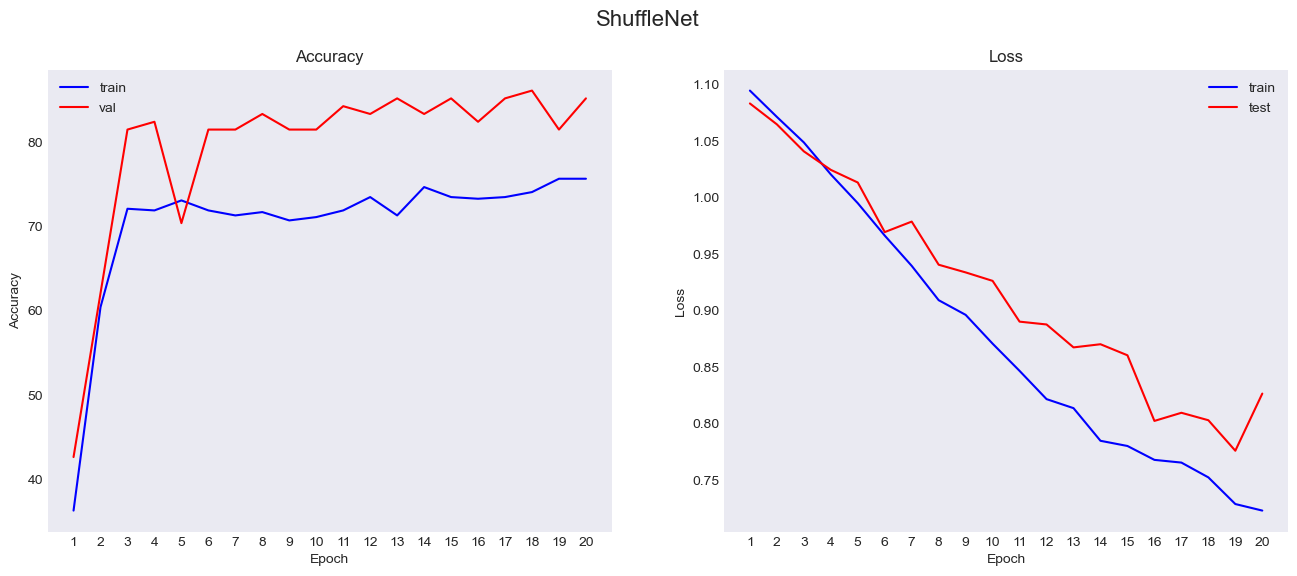

In [356]:
plot_metrics_graph(info, model='ShuffleNet')

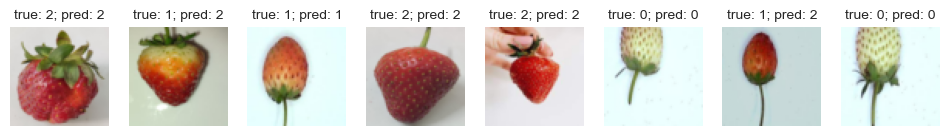

In [359]:
show_model_predictions(model_shufflenet,
                       images_num=8, 
                       dataloader=test_dataloader)

In [103]:
# torch.save(model_resnet.state_dict(), './model_shufflenet')

### MobileNet

In [387]:
model_mobilenet = torchvision.models.mobilenet_v3_small(weights='DEFAULT')

In [388]:
model_mobilenet.classifier[3] = torch.nn.Linear(model_mobilenet.classifier[3].in_features, 3, bias=True)

In [389]:
count_params_num(model_mobilenet)

1520931

In [390]:
optimizer = optim.Adam(model_mobilenet.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)
criterion = torch.nn.CrossEntropyLoss()

In [391]:
info = fit(model=model_mobilenet,
           optimizer=optimizer,
           scheduler=scheduler,
           criterion=criterion,
           epochs=10,
           train_dataloader=train_dataloader,
           val_dataloader=val_dataloader)

Train Epoch: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 1
Loss: 0.8488. Accuracy: 67.5926%


Train Epoch: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 2
Loss: 0.6996. Accuracy: 74.0741%


Train Epoch: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 3
Loss: 0.5928. Accuracy: 82.4074%


Train Epoch: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 4
Loss: 0.5536. Accuracy: 83.3333%


Train Epoch: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 5
Loss: 0.5132. Accuracy: 83.3333%


Train Epoch: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 6
Loss: 0.4741. Accuracy: 87.963%


Train Epoch: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 7
Loss: 0.4383. Accuracy: 89.8148%


Train Epoch: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 8
Loss: 0.4059. Accuracy: 88.8889%


Train Epoch: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 9
Loss: 0.4083. Accuracy: 88.8889%


Train Epoch: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 10
Loss: 0.4452. Accuracy: 87.963%




In [392]:
mobilenet_train_loss_info = validate(
    model=model_mobilenet, 
    criterion=criterion, 
    dataloader=train_dataloader
)

Loss: 0.2733. Accuracy: 93.8614%


In [393]:
mobilenet_val_loss_info = validate(
    model=model_mobilenet, 
    criterion=criterion, 
    dataloader=val_dataloader
)

Loss: 0.3981. Accuracy: 87.963%


In [394]:
mobilenet_test_loss_info = validate(
    model=model_mobilenet, 
    criterion=criterion, 
    dataloader=test_dataloader
)

Loss: 0.3728. Accuracy: 86.2385%


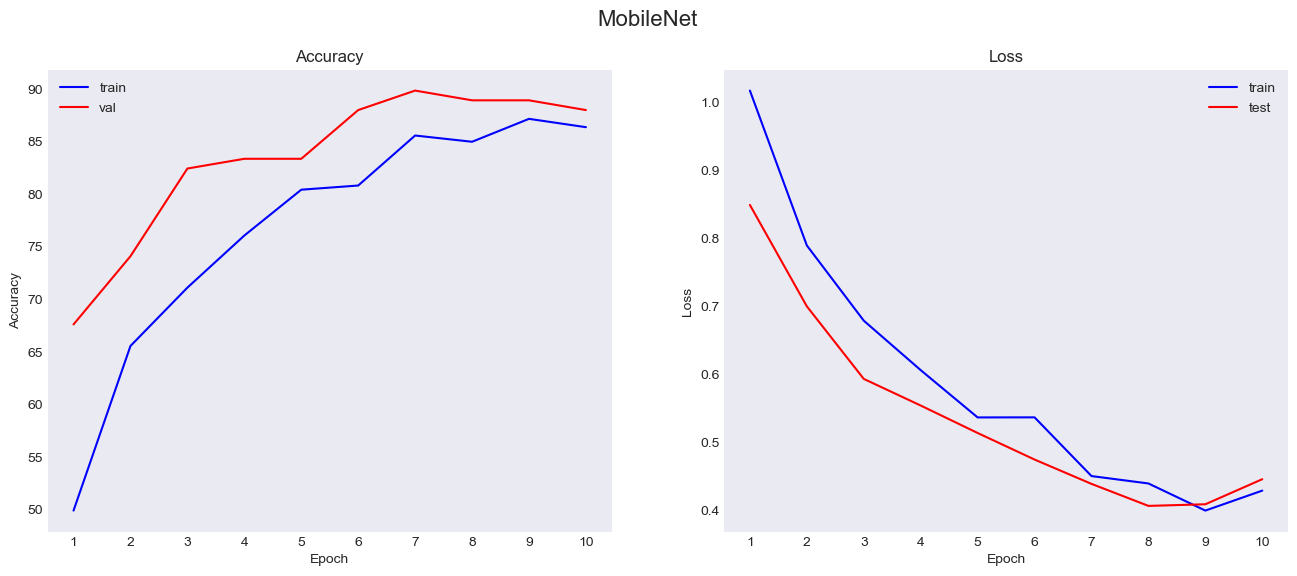

In [395]:
plot_metrics_graph(info, model='MobileNet')

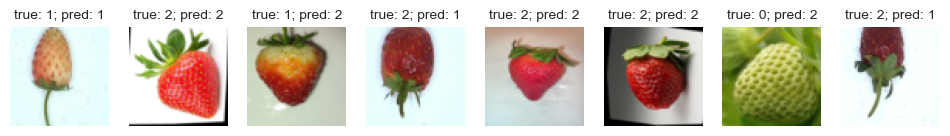

In [396]:
show_model_predictions(model_mobilenet,
                       images_num=8, 
                       dataloader=test_dataloader)

### ResNet

In [363]:
model_resnet = torchvision.models.resnet18(weights='DEFAULT')

In [364]:
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, 3, bias=True)

In [365]:
count_params_num(model_resnet)

11178051

In [366]:
optimizer = optim.Adam(model_resnet.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)
criterion = torch.nn.CrossEntropyLoss()

In [367]:
info = fit(model=model_resnet,
           optimizer=optimizer,
           scheduler=scheduler,
           criterion=criterion,
           epochs=10,
           train_dataloader=train_dataloader,
           val_dataloader=val_dataloader)

Train Epoch: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 1
Loss: 0.1777. Accuracy: 95.3704%


Train Epoch: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 2
Loss: 0.0913. Accuracy: 98.1481%


Train Epoch: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 3
Loss: 0.0623. Accuracy: 98.1481%


Train Epoch: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 4
Loss: 0.0613. Accuracy: 98.1481%


Train Epoch: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 5
Loss: 0.0467. Accuracy: 98.1481%


Train Epoch: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 6
Loss: 0.0387. Accuracy: 99.0741%


Train Epoch: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 7
Loss: 0.0493. Accuracy: 98.1481%


Train Epoch: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 8
Loss: 0.0501. Accuracy: 98.1481%


Train Epoch: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 9
Loss: 0.0334. Accuracy: 98.1481%


Train Epoch: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 10
Loss: 0.0481. Accuracy: 98.1481%




In [368]:
resnet_train_loss_info = validate(
    model=model_resnet, 
    criterion=criterion, 
    dataloader=train_dataloader
)

Loss: 0.0114. Accuracy: 99.802%


In [369]:
resnet_val_loss_info = validate(
    model=model_resnet, 
    criterion=criterion, 
    dataloader=val_dataloader
)

Loss: 0.0466. Accuracy: 98.1481%


In [370]:
resnet_test_loss_info = validate(
    model=model_resnet, 
    criterion=criterion, 
    dataloader=test_dataloader
)

Loss: 0.0517. Accuracy: 98.1651%


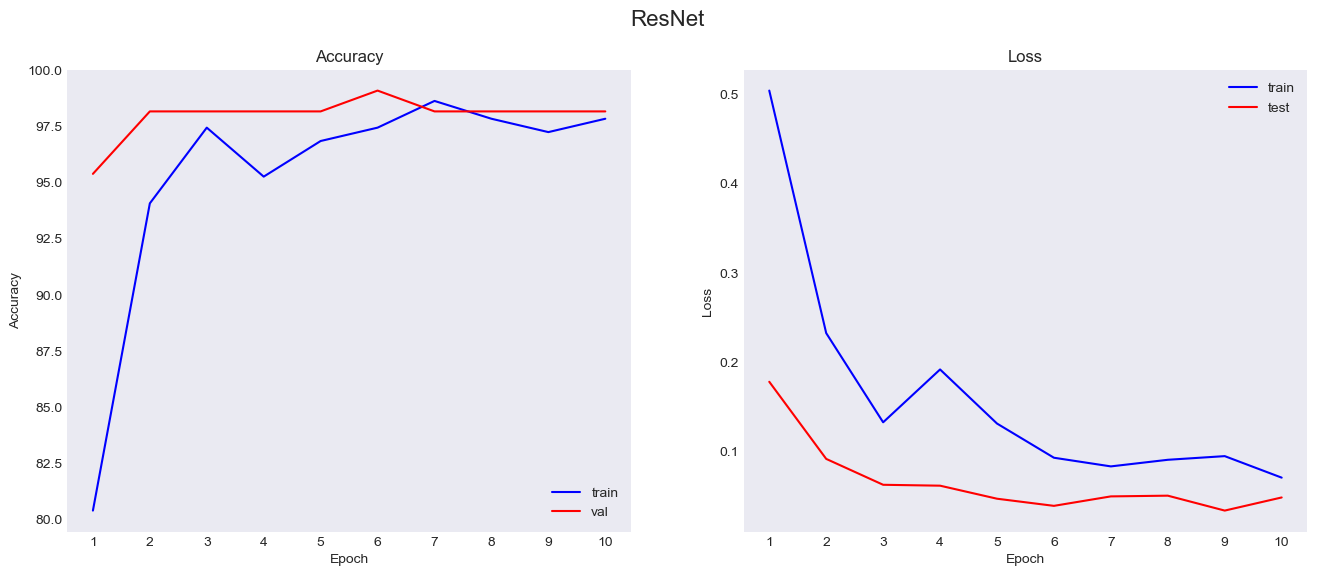

In [371]:
plot_metrics_graph(info, model='ResNet')

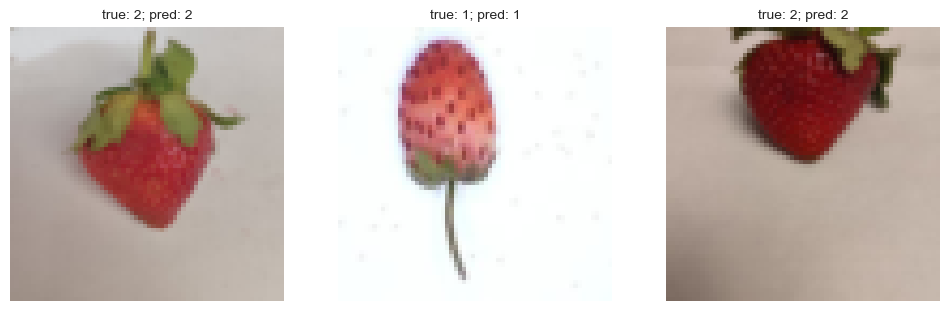

In [372]:
show_model_predictions(model_resnet,
                       images_num=3, 
                       dataloader=test_dataloader)

С помощью архитектуры свёрточных нейронных сетей ResNet удалось достичь 100% Accuracy на тестовой выборке.

In [279]:
torch.save(model_resnet.state_dict(), './model_resnet.pt')

### Swin Transformer

In [373]:
model_swin_t = torchvision.models.swin_t(weights='DEFAULT')

In [40]:
model_swin_t.head = torch.nn.Linear(model_swin_t.head.in_features, 3, bias=True)

In [51]:
count_params_num(model_swin_t)

27521661

In [376]:
optimizer = optim.Adam(model_swin_t.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)
criterion = torch.nn.CrossEntropyLoss()

In [377]:
info = fit(model=model_swin_t,
           optimizer=optimizer,
           scheduler=scheduler,
           criterion=criterion,
           epochs=10,
           train_dataloader=train_dataloader,
           val_dataloader=val_dataloader)

Train Epoch: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 1
Loss: 0.0937. Accuracy: 96.2963%


Train Epoch: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 2
Loss: 0.0433. Accuracy: 99.0741%


Train Epoch: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 3
Loss: 0.0692. Accuracy: 98.1481%


Train Epoch: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 4
Loss: 0.0928. Accuracy: 98.1481%


Train Epoch: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 5
Loss: 0.0383. Accuracy: 99.0741%


Train Epoch: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 6
Loss: 0.0461. Accuracy: 99.0741%


Train Epoch: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 7
Loss: 0.0447. Accuracy: 99.0741%


Train Epoch: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 8
Loss: 0.0611. Accuracy: 99.0741%


Train Epoch: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 9
Loss: 0.055. Accuracy: 98.1481%


Train Epoch: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Validation Epoch: 10
Loss: 0.0537. Accuracy: 99.0741%




In [378]:
model_swin_t_train_loss_info = validate(
    model=model_swin_t, 
    criterion=criterion, 
    dataloader=train_dataloader
)

Loss: 0.0001. Accuracy: 100.0%


In [379]:
model_swin_t_val_loss_info = validate(
    model=model_swin_t, 
    criterion=criterion, 
    dataloader=val_dataloader
)

Loss: 0.0537. Accuracy: 99.0741%


In [380]:
model_swin_t_test_loss_info = validate(
    model=model_swin_t, 
    criterion=criterion, 
    dataloader=test_dataloader
)

Loss: 0.0002. Accuracy: 100.0%


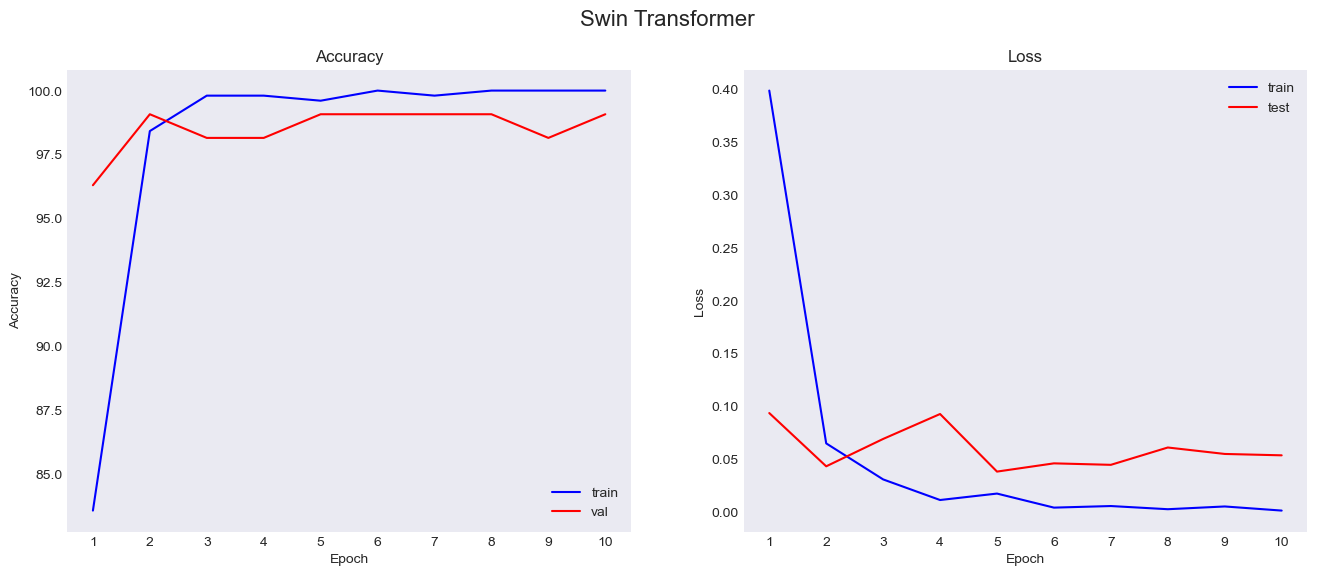

In [381]:
plot_metrics_graph(info, model='Swin Transformer')

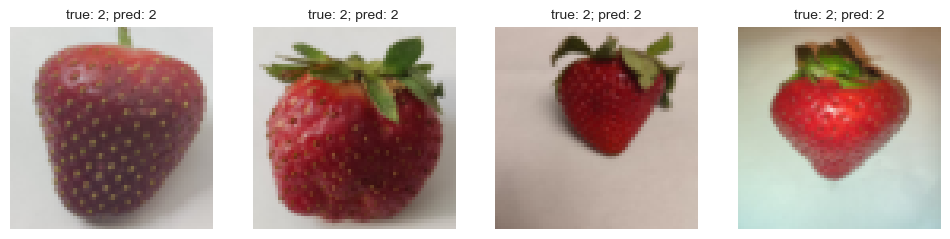

In [401]:
show_model_predictions(model_swin_t,
                       images_num=4,
                       dataloader=test_dataloader)

In [383]:
torch.save(model_swin_t.state_dict(), './model_swin_t.pt')

In [397]:
all_metrics_list = []
all_loss_info_list = [
    (shufflenet_train_loss_info, shufflenet_val_loss_info, shufflenet_test_loss_info),
    (mobilenet_train_loss_info, mobilenet_val_loss_info, mobilenet_test_loss_info),
    (resnet_train_loss_info, resnet_val_loss_info, resnet_test_loss_info),
    (model_swin_t_train_loss_info, model_swin_t_val_loss_info, model_swin_t_test_loss_info)
]

for (train_loss_info, val_loss_info, test_loss_info) in all_loss_info_list:
    train_accuracy = train_loss_info['accuracy']
    val_accuracy = val_loss_info['accuracy']
    test_accuracy = test_loss_info['accuracy']
    clf_metrics_list = [train_accuracy, val_accuracy, test_accuracy]
    all_metrics_list.append(clf_metrics_list)

compare_df = pd.DataFrame(data=all_metrics_list, 
                          index=['ShuffleNet', 'MobileNet', 'ResNet', 'Swin Transformer'],
                          columns=['Train', 'Validation', 'Test'])

In [398]:
compare_df

,Train,Validation,Test
ShuffleNet,85.5446,85.1852,77.0642
MobileNet,93.8614,87.9630,86.2385
ResNet,99.8020,98.1481,98.1651
Swin Transformer,100.0000,99.0741,100.0000


In [178]:
# image = torch.permute(train_dataset[0][0], (1, 2, 0)).numpy()

In [183]:
# inference(model_shufflenet, image)